In [1]:
!kaggle datasets download -d tomtillo/satellite-image-caption-generation

Dataset URL: https://www.kaggle.com/datasets/tomtillo/satellite-image-caption-generation
License(s): CC0-1.0
100% 119M/119M [00:08<00:00, 17.7MB/s]
100% 119M/119M [00:08<00:00, 14.4MB/s]


In [2]:
!unzip /content/satellite-image-caption-generation.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/mountain_327.jpg  
  inflating: train/mountain_328.jpg  
  inflating: train/mountain_329.jpg  
  inflating: train/mountain_33.jpg   
  inflating: train/mountain_330.jpg  
  inflating: train/mountain_331.jpg  
  inflating: train/mountain_332.jpg  
  inflating: train/mountain_333.jpg  
  inflating: train/mountain_334.jpg  
  inflating: train/mountain_335.jpg  
  inflating: train/mountain_336.jpg  
  inflating: train/mountain_337.jpg  
  inflating: train/mountain_338.jpg  
  inflating: train/mountain_339.jpg  
  inflating: train/mountain_34.jpg   
  inflating: train/mountain_340.jpg  
  inflating: train/mountain_35.jpg   
  inflating: train/mountain_36.jpg   
  inflating: train/mountain_37.jpg   
  inflating: train/park_1.jpg        
  inflating: train/park_10.jpg       
  inflating: train/park_100.jpg      
  inflating: train/park_101.jpg      
  inflating: train/park_102.jpg      
  inflating: train/park_103.jpg      

In [123]:
import pandas as pd
df_train=pd.read_csv('/content/train.csv')
df_train.head()

captions               filepath
0  ['Many aircraft are parked next to a long buil...    train/airport_1.jpg
1  ['some planes are parked in an airport.'\n 'th...   train/airport_10.jpg
2  ['Many aircraft are parked in an airport near ...  train/airport_100.jpg
3  ['Many aircraft are parked near a large buildi...  train/airport_101.jpg
4  ['several buildings and green trees are around...  train/airport_102.jpg

In [22]:
df_train['captions']=df_train['captions']

In [28]:
res=df_train['captions'].values

array(["['Many aircraft are parked next to a long building in an airport.'\n 'Many planes are parked next to a long building at an airport.'\n 'Many planes are parked next to a long building in an airport.'\n 'many planes are parked next to a long building at an airport.'\n 'many planes are parked next to a long building in an airport .']",
       "['Many aircraft are parked next to a long building in an airport.'\n 'Many planes are parked next to a long building at an airport.'\n 'Many planes are parked next to a long building in an airport.'\n 'many planes are parked next to a long building at an airport.'\n 'many planes are parked next to a long building in an airport .']",
       "['Many aircraft are parked next to a long building in an airport.'\n 'Many planes are parked next to a long building at an airport.'\n 'Many planes are parked next to a long building in an airport.'\n 'many planes are parked next to a long building at an airport.'\n 'many planes are parked next to a long 

In [124]:
import cv2 as cv
import os
data_dir='/content/'
img=cv.imread(os.path.join(data_dir,df_train.iloc[0,1]))

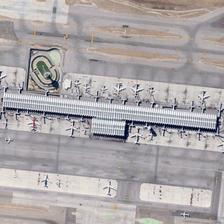

In [125]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [126]:
img.shape

(224, 224, 3)

In [127]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [128]:
model=VGG16()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
features={}


for img_name in tqdm(os.listdir('/content/train')):
  img_path=os.path.join('/content/train',img_name)
  img=load_img(img_path,target_size=(224,224))
  img=img_to_array(img)
  img=img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
  image=preprocess_input(img)
  feature=model.predict(image,verbose=0)
  img_id=img_name.split('.')[0]
  features[img_id]=feature

  0%|          | 0/8734 [00:00<?, ?it/s]

In [130]:
import pickle
import os

with open(os.path.join('/content/outputs', 'features.pkl'), 'wb') as file:
    pickle.dump(features, file)


In [131]:

with open('/content/train.csv','r') as f:
  next(f)
  content_doc=f.read()

In [132]:
content_doc

'"[\'Many aircraft are parked next to a long building in an airport.\'\n \'Many planes are parked next to a long building at an airport.\'\n \'Many planes are parked next to a long building in an airport.\'\n \'many planes are parked next to a long building at an airport.\'\n \'many planes are parked next to a long building in an airport .\']",train/airport_1.jpg\n"[\'some planes are parked in an airport.\'\n \'the airport here is full of planes and containers.\'\n \'the airport here is full of airplanes and containers .\'\n \'Some planes are parked at an airport.\'\n \'some planes are parked in an airport .\']",train/airport_10.jpg\n"[\'Many aircraft are parked in an airport near many runways.\'\n \'There are a lot of the same size planes in the airport.\'\n \'there are many planes with same size in the airport .\'\n \'Many planes are parked at an airport near many runways.\'\n \'many planes are parked in an airport near many runways .\']",train/airport_100.jpg\n"[\'Many aircraft are 

In [133]:
mappings={}
for index,i in df_train.iterrows():
  full=i['filepath']
  res=full.split('.')[0]
  res=res.split('/')[1]
  caps=i['captions'].split('\n')
  if res not in mappings:
    mappings[res]=[]
  for j in range(len(caps)):
    mappings[res].append(caps[j])




In [134]:
mappings

{'airport_1': ["['Many aircraft are parked next to a long building in an airport.'",
  " 'Many planes are parked next to a long building at an airport.'",
  " 'Many planes are parked next to a long building in an airport.'",
  " 'many planes are parked next to a long building at an airport.'",
  " 'many planes are parked next to a long building in an airport .']"],
 'airport_10': ["['some planes are parked in an airport.'",
  " 'the airport here is full of planes and containers.'",
  " 'the airport here is full of airplanes and containers .'",
  " 'Some planes are parked at an airport.'",
  " 'some planes are parked in an airport .']"],
 'airport_100': ["['Many aircraft are parked in an airport near many runways.'",
  " 'There are a lot of the same size planes in the airport.'",
  " 'there are many planes with same size in the airport .'",
  " 'Many planes are parked at an airport near many runways.'",
  " 'many planes are parked in an airport near many runways .']"],
 'airport_101': [

In [135]:
import re
def clean(mappings):
  for key, caps in mappings.items():
    for i in range(len(caps)):
      cap=caps[i]
      cap=cap.lower()
      cap = re.sub(r'[^A-Za-z\s]', '', cap)
      cap = re.sub(r'\s+', ' ', cap).strip()
      cap = 'startseq ' + " ".join([word for word in cap.split() if len(word) > 1]) + ' endseq'
      caps[i]=cap

In [136]:
clean(mappings)

In [137]:
len(mappings)

8734

In [138]:
all_captions = []
for key in mappings:
    for caption in mappings[key]:
        all_captions.append(caption)

In [139]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [140]:
vocab_size=len(tokenizer.word_index)+1

In [141]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [142]:
image_ids = list(mappings.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [143]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:  # Infinite loop to generate batches
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):  # Use range correctly
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])  # Image features
                    X2.append(in_seq)            # Input sequence
                    y.append(out_seq)            # Output word (one-hot encoded)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()  # Reset lists for the next batch
                n = 0


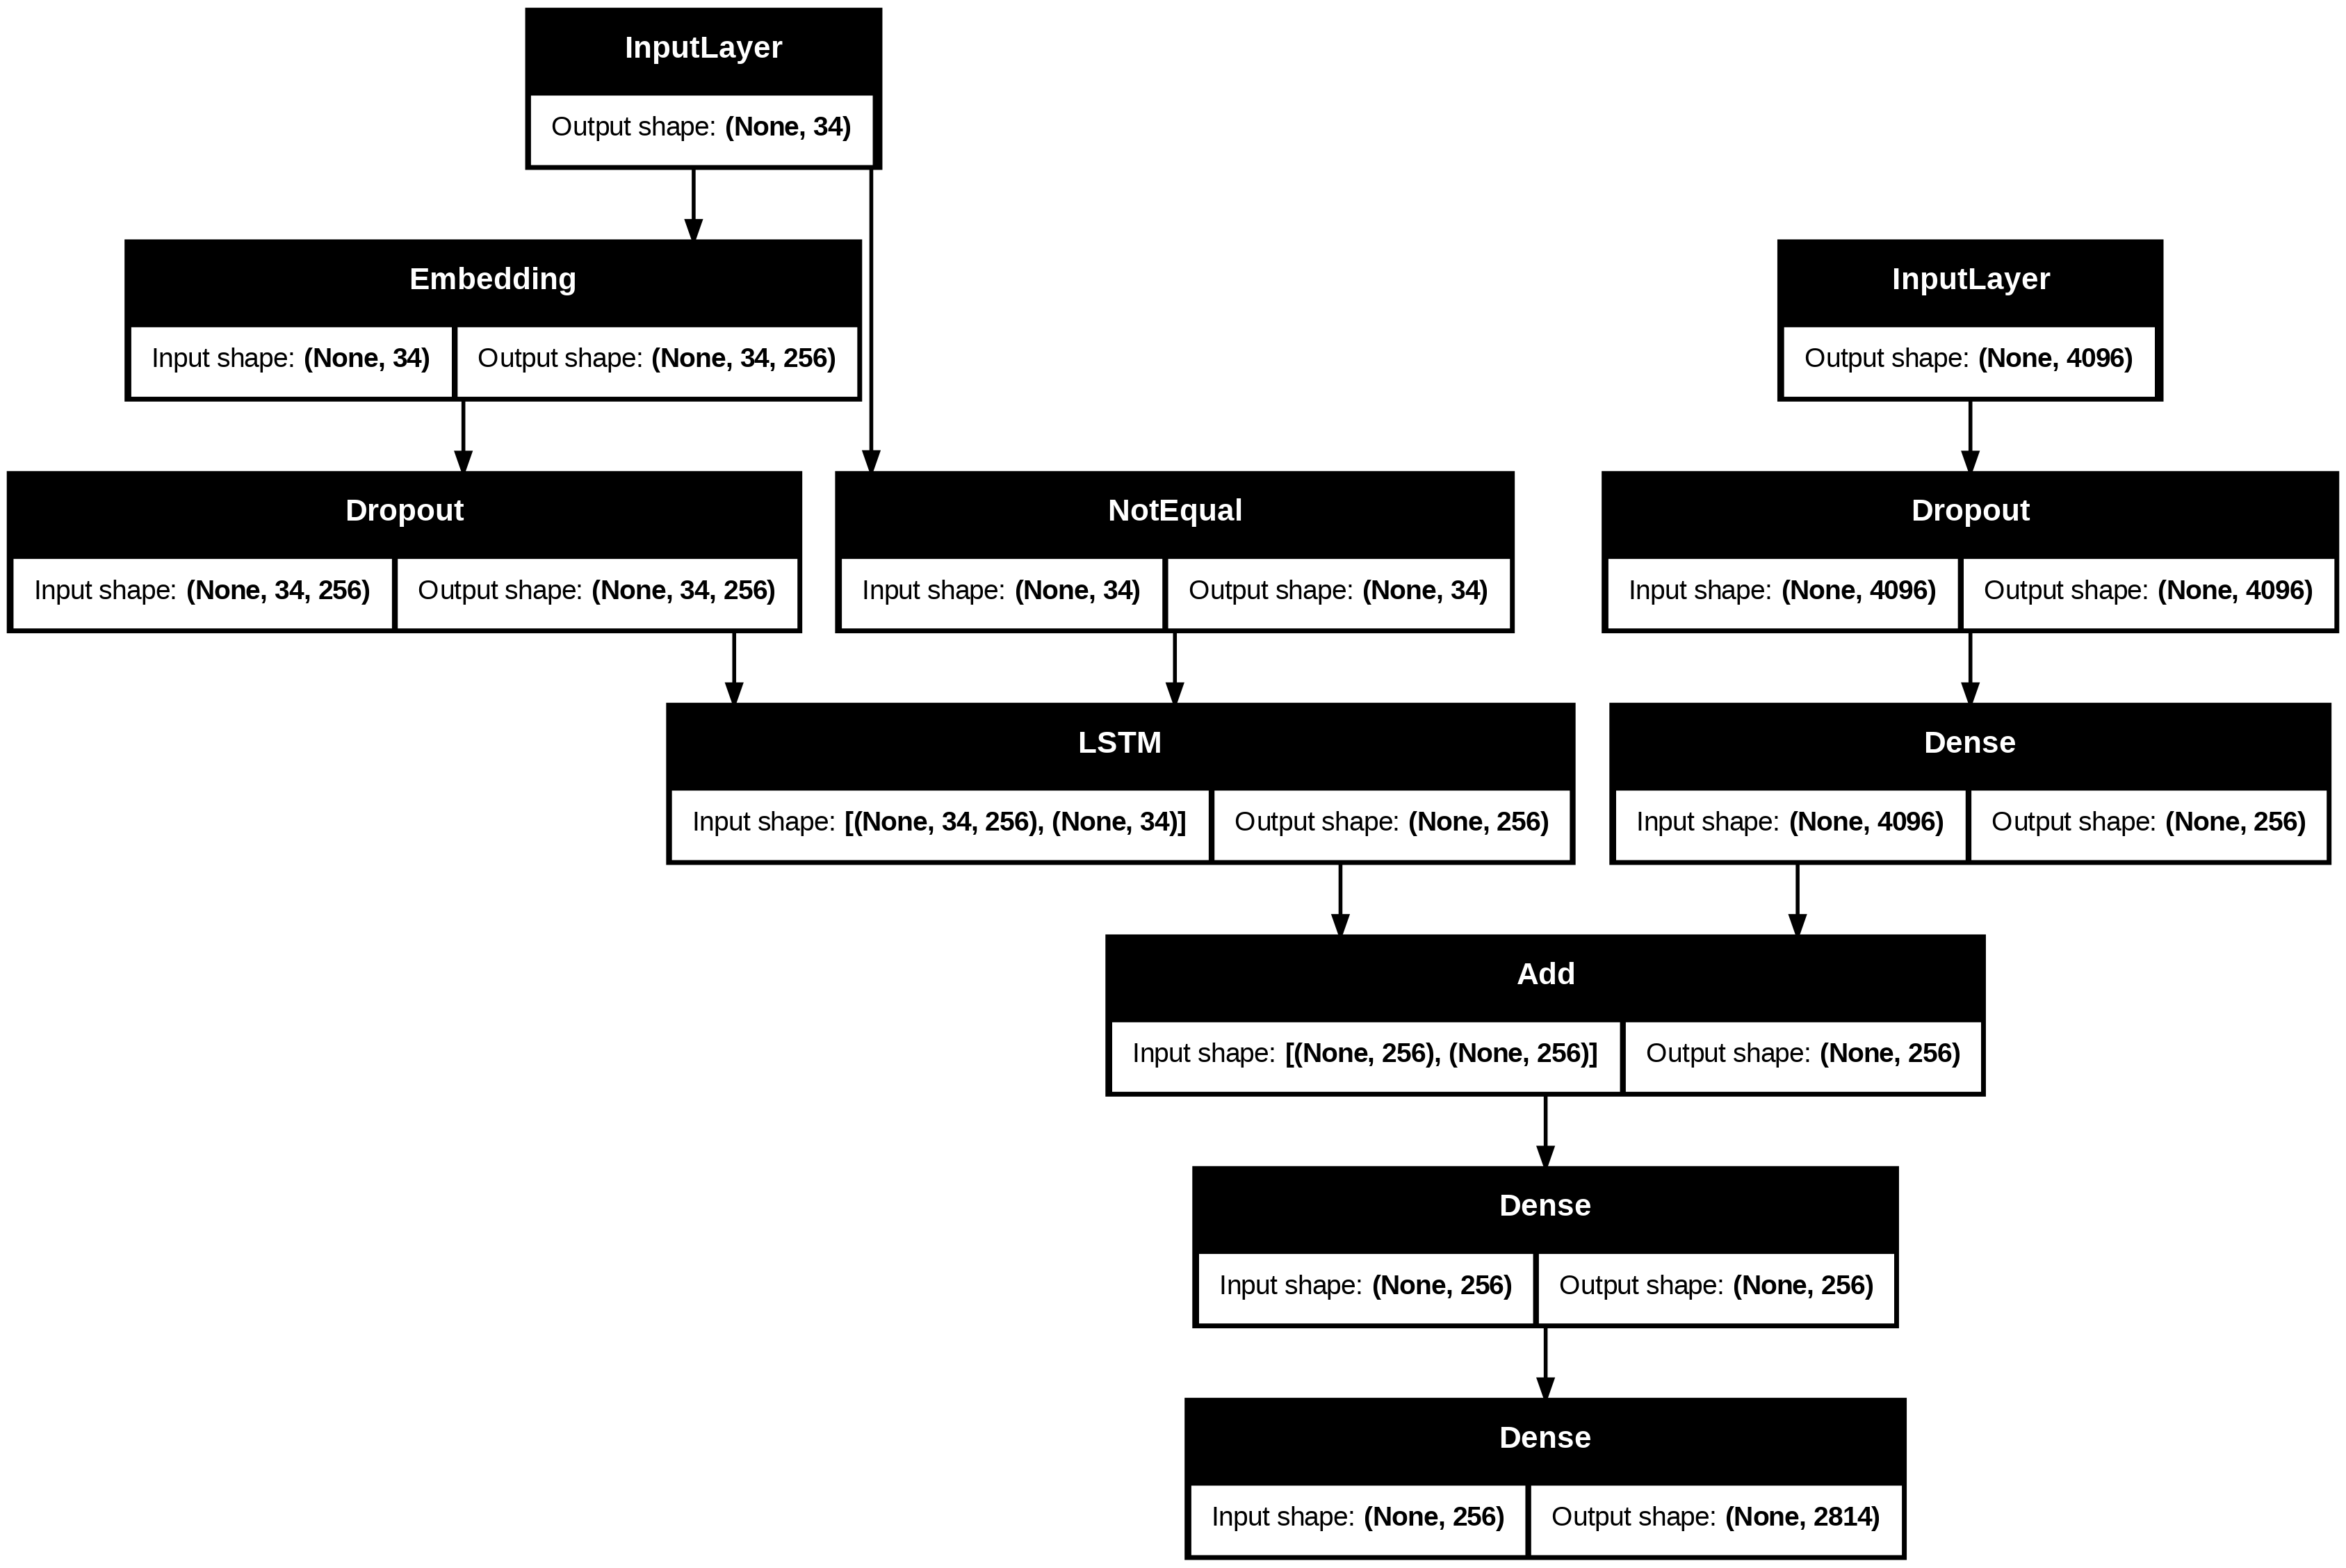

In [144]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data gener


    generator = data_generator(train, mappings, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)

#model.save(output_dir+'/best_model.h5')

Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - loss: 1.2205
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - loss: 1.2004
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - loss: 1.1857
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - loss: 1.1682
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.1477
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - loss: 1.1433
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - loss: 1.1365
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - loss: 1.1248
Epoch 9/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - loss: 1.1135
Epoch 10/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 1.0944
Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - loss: 1.0930
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - loss: 1.0727
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - loss: 1.0532
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - loss: 1.0353
Epoch 5/10
245/245 

In [147]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


In [148]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length,padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [149]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mappings[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/874 [00:00<?, ?it/s]

BLEU-1: 0.500000
BLEU-2: 0.369274
BLEU-1: 0.681818
BLEU-2: 0.488504
BLEU-1: 0.794118
BLEU-2: 0.659912
BLEU-1: 0.760870
BLEU-2: 0.601929
BLEU-1: 0.775862
BLEU-2: 0.616937
BLEU-1: 0.768116
BLEU-2: 0.604789
BLEU-1: 0.765373
BLEU-2: 0.610537
BLEU-1: 0.741759
BLEU-2: 0.591357
BLEU-1: 0.739472
BLEU-2: 0.599448
BLEU-1: 0.748518
BLEU-2: 0.618778
BLEU-1: 0.761272
BLEU-2: 0.631213
BLEU-1: 0.740001
BLEU-2: 0.606989
BLEU-1: 0.752697
BLEU-2: 0.621120
BLEU-1: 0.747503
BLEU-2: 0.618580
BLEU-1: 0.730616
BLEU-2: 0.597816
BLEU-1: 0.725266
BLEU-2: 0.577711
BLEU-1: 0.720335
BLEU-2: 0.573655
BLEU-1: 0.704194
BLEU-2: 0.556962
BLEU-1: 0.697987
BLEU-2: 0.556851
BLEU-1: 0.700720
BLEU-2: 0.561179
BLEU-1: 0.694010
BLEU-2: 0.554440
BLEU-1: 0.690023
BLEU-2: 0.546843
BLEU-1: 0.685968
BLEU-2: 0.539796
BLEU-1: 0.694368
BLEU-2: 0.542541
BLEU-1: 0.693367
BLEU-2: 0.533529
BLEU-1: 0.694454
BLEU-2: 0.536051
BLEU-1: 0.692554
BLEU-2: 0.532830
BLEU-1: 0.693777
BLEU-2: 0.530962
BLEU-1: 0.698707
BLEU-2: 0.540195
BLEU-1: 0.6969

In [152]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/train', image_name)
    image = Image.open(img_path)
    captions = mappings[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq road is under repair with some buildings beside endseq
startseq curved river with grey water through many blue jars endseq
startseq many blue buildings are around some white tanks endseq
startseq many blue buildings and some white storange are around some white storange tanks endseq
startseq some white storage tanks are semisurrounded by many blue simple workshop endseq
--------------------Predicted--------------------
startseq many buildings are around square with some green trees endseq


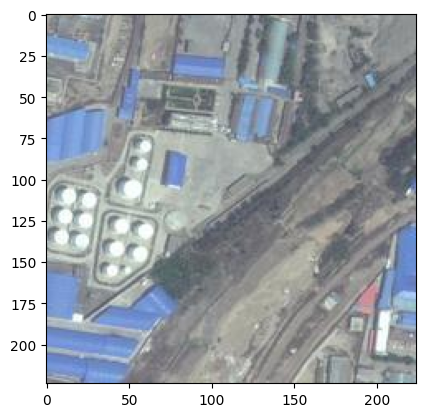

In [157]:
generate_caption("00011.jpg")